In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt
from data_loader import ImageDataset2025
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [2]:
# Define Transforms
# ResNet expects 224x224 input.
# The dataset loads images as grayscale ("L").
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

# Load Dataset
dataset = ImageDataset2025(
    base_dir="data/2025_Dataset", mode="pose", multi_label=False, transform=transform
)

num_classes = len(dataset.idx_to_label)
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {dataset.idx_to_label}")

INFO:root:Loaded 2002 pose samples from data/2025_Dataset with 40 classes


Total samples: 2002
Number of classes: 40
Classes: ['P0_R0', 'P10_R0', 'P15_R0', 'P15_R15', 'P15_R30', 'P15_R45', 'P15_R5', 'P25_R0', 'P30_R0', 'P30_R10', 'P30_R15', 'P30_R30', 'P30_R45', 'P30_R5', 'P30_R60', 'P35_R0', 'P40_R0', 'P45_R0', 'P45_R10', 'P45_R15', 'P45_R30', 'P45_R45', 'P45_R5', 'P45_R60', 'P50_R0', 'P55_R0', 'P5_R0', 'P60_R0', 'P60_R10', 'P60_R15', 'P60_R30', 'P60_R45', 'P60_R5', 'P60_R60', 'P65_R0', 'P70_R0', 'P75_R0', 'P80_R0', 'P85_R0', 'P90_R0']


In [3]:
# Split Dataset
# 1. Split 0.1 for Test set
total_len = len(dataset)
test_len = int(0.1 * total_len)
train_val_len = total_len - test_len

train_val_dataset, test_dataset = random_split(dataset, [train_val_len, test_len])

# 2. Within the training set (train_val_dataset), split 0.1 for Validation set
val_len = int(0.1 * train_val_len)
train_len = train_val_len - val_len

train_dataset, val_dataset = random_split(train_val_dataset, [train_len, val_len])

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 1622
Validation set size: 180
Test set size: 200


In [4]:
# Setup Model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the first convolutional layer to accept 1 channel (grayscale) instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
MODEL_PATH = "model/resnet18_pose_model_single_label.pth"
N_EPOCHS = 16
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model (by validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Acc: {val_acc:.4f})")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:07<00:00,  6.96it/s]


Saved best model to resnet18_pose_model_single_label.pth (Val Acc: 0.8833)
Epoch 1/16 - Train Loss: 1.2956 Acc: 0.6245 | Val Loss: 0.3605 Acc: 0.8833


100%|██████████| 51/51 [00:06<00:00,  7.36it/s]


Saved best model to resnet18_pose_model_single_label.pth (Val Acc: 0.9611)
Epoch 2/16 - Train Loss: 0.2122 Acc: 0.9482 | Val Loss: 0.2151 Acc: 0.9611


100%|██████████| 51/51 [00:07<00:00,  7.20it/s]


Epoch 3/16 - Train Loss: 0.0861 Acc: 0.9784 | Val Loss: 0.1565 Acc: 0.9500


100%|██████████| 51/51 [00:07<00:00,  7.15it/s]


Saved best model to resnet18_pose_model_single_label.pth (Val Acc: 0.9889)
Epoch 4/16 - Train Loss: 0.0561 Acc: 0.9852 | Val Loss: 0.0429 Acc: 0.9889


100%|██████████| 51/51 [00:06<00:00,  7.29it/s]


Saved best model to resnet18_pose_model_single_label.pth (Val Acc: 0.9944)
Epoch 5/16 - Train Loss: 0.0393 Acc: 0.9926 | Val Loss: 0.0216 Acc: 0.9944


100%|██████████| 51/51 [00:06<00:00,  7.32it/s]


Epoch 6/16 - Train Loss: 0.0210 Acc: 0.9957 | Val Loss: 0.0290 Acc: 0.9889


100%|██████████| 51/51 [00:06<00:00,  7.33it/s]


Epoch 7/16 - Train Loss: 0.0225 Acc: 0.9975 | Val Loss: 0.0173 Acc: 0.9889


100%|██████████| 51/51 [00:06<00:00,  7.33it/s]


Epoch 8/16 - Train Loss: 0.0180 Acc: 0.9982 | Val Loss: 0.0194 Acc: 0.9944


100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


Epoch 9/16 - Train Loss: 0.0109 Acc: 0.9994 | Val Loss: 0.0660 Acc: 0.9667


100%|██████████| 51/51 [00:06<00:00,  7.30it/s]


Saved best model to resnet18_pose_model_single_label.pth (Val Acc: 1.0000)
Epoch 10/16 - Train Loss: 0.0162 Acc: 0.9969 | Val Loss: 0.0167 Acc: 1.0000


100%|██████████| 51/51 [00:06<00:00,  7.32it/s]


Epoch 11/16 - Train Loss: 0.0676 Acc: 0.9840 | Val Loss: 0.1722 Acc: 0.9444


100%|██████████| 51/51 [00:06<00:00,  7.34it/s]


Epoch 12/16 - Train Loss: 0.0970 Acc: 0.9778 | Val Loss: 0.1176 Acc: 0.9667


100%|██████████| 51/51 [00:06<00:00,  7.32it/s]


Epoch 13/16 - Train Loss: 0.0779 Acc: 0.9815 | Val Loss: 0.0671 Acc: 0.9833


100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


Epoch 14/16 - Train Loss: 0.0289 Acc: 0.9920 | Val Loss: 0.0902 Acc: 0.9778


100%|██████████| 51/51 [00:07<00:00,  7.28it/s]


Epoch 15/16 - Train Loss: 0.0079 Acc: 0.9982 | Val Loss: 0.0181 Acc: 0.9944


100%|██████████| 51/51 [00:06<00:00,  7.37it/s]


Epoch 16/16 - Train Loss: 0.0015 Acc: 1.0000 | Val Loss: 0.0049 Acc: 1.0000


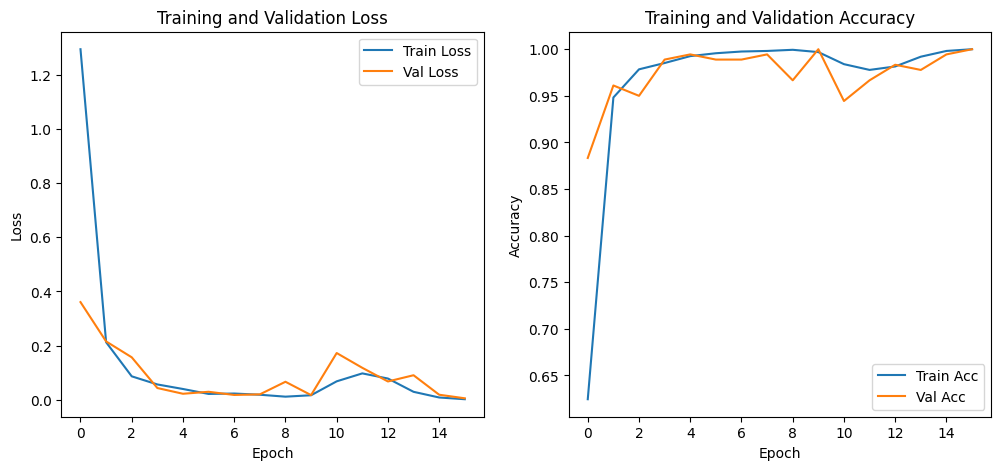

In [6]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

In [11]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_acc_loaded = checkpoint.get("val_acc")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_acc={val_acc_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Loaded checkpoint from model/resnet18_pose_model_single_label.pth (epoch=10, val_acc=1.0, val_loss=0.016695673970712557)
Test Set Accuracy: 0.9650
